# membrane
+ special Pf_RS and RS_plot
+ limit state: structure age > membrane life

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import stats
import numpy as np
from helper_func import *

In [2]:
# special functions for this module
def Pf_RS_special(R_info, S, R_distrib_type='normal', plot=False): 
    """special case where S is a number"""
    from scipy import integrate
    if isinstance(int(S),int):
        try:
            if R_distrib_type == 'normal':
                # R = (mu, std)
                (m, s) = R_info
                R_distrib = stats.norm(m, s)
                R = R_distrib.rvs(size=N_SAMPLE)

                # Calculate probablility of failure
                pf_RS = R_distrib.cdf(S)
        except:
            print('R is not configured')
    else:
        print('S is not configured')

    # compare with
    # numerical g
    g = R - S
    g = g[~np.isnan(g)]
    # numerical kernel fit
    g_kde_fit = Fit_distrib(g, fit_type='kernel', plot=False)

    pf_kde = integrate.quad(g_kde_fit, g.min(), 0)[0]
    pf_sample = len(g[g < 0]) / len(g)
    beta_factor = g.mean() / g.std()  # first order

    if plot:
        print('Pf(g = R-S < 0) from various methods')
        print('    sample count: {}'.format(pf_sample))
        print('    g integral: {}'.format(pf_kde))
        print('    R S integral: {}'.format(pf_RS))
        # printmd('$\int\limits_{-\infty}^{\infty} F_R(x)f_S(x)dx$')
        print('    beta_factor: {}'.format(beta_factor))

        # Plot R S
        fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10, 3))
        # R
        R_plot = np.linspace(R.min(), R.max(), 100)
        ax1.plot(R_plot, R_distrib.pdf(R_plot), color='C0')
        ax1.hist(R, bins=min(N_SAMPLE // 100, 100), density=True, alpha=0.5, color='C0', label='R')

        # S updated
        ax1.vlines(x=S, ymin=0, ymax = R_distrib.pdf(R_info[0]), color='C1', alpha=1, label ='S') # updated
        
        ax1.set_title('S: {:.1f}'.format(S))
        ax1.legend()
        plt.tight_layout()

        # plot g
        g_plot = np.linspace(g.min(), g.max(), 100)
        ax2.plot(g_plot, g_kde_fit(g_plot), color='C2', alpha=1)

        ax2.hist(g, density=True, bins=min(N_SAMPLE // 100, 100), color='C2', alpha=0.5, label='g=R-S')
        ax2.vlines(x=0, ymin=0, ymax=g_kde_fit(0)[0], linestyles='--', alpha=0.5)
        ax2.vlines(x=g.mean(), ymin=0, ymax=g_kde_fit(g.mean())[0], linestyles='--', alpha=0.5)
        #         ax.annotate(s='', xy=(0,g_kde_fit(0)[0]), xytext=(g.mean(),g_kde_fit(0)[0]),
        #                     arrowprops={'arrowstyle': '<->'},va='center')
        ax2.annotate(s=r'$\{mu}_g$', xy=(0, g.mean()), xytext=(g.mean(), g_kde_fit(0)[0]),
                     va='center')
        ax2.legend()
        ax2.set_title('Limit-state P(g<0)={}'.format(pf_RS))
        plt.show()

    return pf_RS, beta_factor, R_distrib

def RS_plot_special(model, ax=None, t_offset=0, amplify=1):  # updated!
    """plot R S distribution vertically at a time to an axis
    
    Parameters
    ----------
    model : model object
    model.R_distrib : scipy.stats._continuous_distns, normal or beta
                      calculated in Pf_RS() through model.postproc()
    model.S : single number for this special case

    ax : axis
    t_offset : time offset to move the plot along the t-axis. default is zero
    amplify : scale the height of the pdf plot
    """
    
    R_distrib = model.R_distrib
    S = model.S
    
    S_dropna = S[~np.isnan(S)]
    # Plot R S
    R = R_distrib.rvs(size=N_SAMPLE)

    if ax == None:
        ax = plt.gca()
    # R
    R_plot = np.linspace(R.min(), R.max(), 100)
    ax.plot(R_distrib.pdf(R_plot) * amplify + t_offset, R_plot, color='C0')
    ax.fill_betweenx(R_plot, t_offset, R_distrib.pdf(R_plot) * amplify + t_offset, color='C0', alpha=0.5, label = 'R')
    # S
    S_plot = np.linspace(S_dropna.min(), S_dropna.max(), 100)
    ax.hlines(y=S, xmin=0 *amplify + t_offset, 
              xmax= R_distrib.pdf(R.mean())*amplify + t_offset, 
              color='C1', alpha=1, label = 'S')



In [3]:
# model function
def current_age(t):
    return t

def membrane_life(pars):
    """calculate mean value of the membrane with assumed std"""
    life_mean = find_mean(val=pars.life_product_label_life,  # find_mean is a helper function in helper_func.py
                           s=pars.life_std, 
                           confidence_one_tailed = pars.life_confidence)
    return life_mean
    
# calibrate Resistance to match the probability
def calbrate_f(model_raw, t, membrane_failure_ratio_field, tol=1e-6, max_count=100, print_out=True):
    """find corresponding membrane service life std that matches the failure ratio in the field"""
    model = model_raw.copy()
    std_min = 0.
    std_max = 100. # year, unrealistic large safe ceiling
    # optimization
    count = 0
    while std_max - std_min > tol:
        # update guess
        std_guess = 0.5 * (std_min + std_max)
        model.pars.life_std = std_guess
        model.run(t)
        model.postproc()
        
        # compare 
        if model.pf < membrane_failure_ratio_field:
            # narrow the cap
            std_min = max(std_guess, std_min)
        else:
            std_max = min(std_guess, std_max)
            
        # print([std_min, std_max])
        count += 1
        if count > max_count:
            break

    if print_out:
        print('probability of failure:')
        print('model: {}'.format(model.pf))
        print('field: {}'.format(membrane_failure_ratio_field))
    return model

    


In [4]:
class Membrane_Model:
    def __init__(self, pars):
        self.pars = pars
        
    def run(self, t):
        self.t = t
        self.age = current_age(t)
        self.pars.life_mean = membrane_life(self.pars)
    
    def postproc(self, plot=False):
        sol = Pf_RS_special((self.pars.life_mean,self.pars.life_std),self.age, R_distrib_type='normal', plot = plot)
        self.pf = sol[0]
        self.beta_factor = sol[1]
        self.R_distrib = sol[2]
        self.S = self.age

    def copy(self):
        return deepcopy(self)


In [6]:
# Case study
# global
class Param: pass

raw_pars = Param()

# product information
raw_pars.life_product_label_life = 10  # year, defined as 95% confident non-failure
raw_pars.life_std = 0.2 * raw_pars.life_product_label_life # assume, calibrate later
raw_pars.life_confidence = 0.95



Pf(g = R-S < 0) from various methods
    sample count: 0.0489
    g integral: 0.0498160778778962
    R S integral: 0.05000000000001138
    beta_factor: 1.6556013809429406


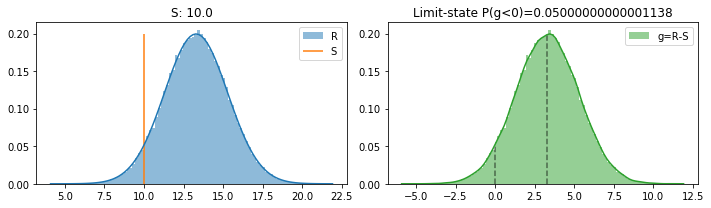

In [7]:
# run model
M = Membrane_Model(raw_pars)
M.run(10)
M.postproc(plot=True)

In [24]:
# calibration to field data 
# field
raw_pars.membrane_failure_ratio_field = 0.01

M_cal = calbrate_f(M,5,raw_pars.membrane_failure_ratio_field)




probability of failure:
model: 0.00999999836471112
field: 0.01


# Construction zone

In [25]:
t_lis = np.arange(0,21,1)
M_lis = []
for t in t_lis:
    M.run(t)
    M.postproc()
    M_lis.append(M.copy())

In [26]:
fig,[ax1,ax2,ax3] = plt.subplots(nrows = 3, figsize=(8,8),sharex=True,gridspec_kw={'height_ratios': [1,1,3]})
# plot a few distrubtion
t_plot = np.array([2,5,10,15,20]).astype('float')
indx =  [i for i, val in enumerate(t_lis) if val in set(t_plot)]
# seleted M to plot pdf
M_sel = [M_lis[i] for i in indx] 

ax1.plot([this_M.t for this_M in M_lis], [this_M.pf for this_M in M_lis],'k--')
ax1.plot([this_M.t for this_M in M_sel], [this_M.pf for this_M in M_sel],'k|',markersize=15)
ax1.set_ylabel('Probability of failure $P_f$')

ax2.plot([this_M.t for this_M in M_lis], [this_M.beta_factor for this_M in M_lis], 'k--')
ax2.plot([this_M.t for this_M in M_sel], [this_M.beta_factor for this_M in M_sel], 'k|',markersize=15)
ax2.set_ylabel(r'Reliability factor $\beta$')

# plot mean results
ax3.plot(t_lis, [M.pars.life_mean for M in M_lis], '--C0')
ax3.plot(t_lis, [M.age for M in M_lis], '--C1')
# plot distribution
for this_M in M_sel:
    RS_plot_special(this_M, ax=ax3, t_offset=this_M.t, amplify=10)

import matplotlib.patches as mpatches
R_patch = mpatches.Patch(color='C0', label='R: membrane life',alpha=0.8)
S_patch = mpatches.Patch(color='C1', label='S: age',alpha=0.8)

ax3.set_xlabel('Time[year]')
ax3.set_ylabel('age/membrane life [year')
ax3.legend(handles=[R_patch, S_patch],loc='upper left')

plt.tight_layout()

<IPython.core.display.Javascript object>